# Bike sharing in Oslo
Runar Helin and Jon Nordby
<br>September 2017

In [2]:
%load_ext autoreload

%matplotlib inline
%autoreload 2

import math
# Supress nosiy deprecation warning from inside matplotlib
import warnings
warnings.filterwarnings('ignore')

# Part of Anaconda distribution
import numpy
import pandas
import matplotlib
import matplotlib.pyplot as plt

# External dependencies
# pip install geopy graphviz folium
import folium

# Custom code developed for the notebook, ./oslo.py
import oslo

matplotlib.rcParams['figure.figsize'] = (14, 8)

In [3]:
# Download raw data
start = (2016, 6)
end = (2016, 7)
notexisting = [(2017, 1), (2017, 2), (2017, 3) ]
periods = sorted(set(oslo.months_between(start, end)).difference(notexisting))
for period in periods:
    try:
        filename = oslo.download_trip(*period)
    except Exception as e:
        raise RuntimeError("Could not download %d-%d: %s" % (*period, e.msg))

using existing trips-2016.6.1-2016.6.30.csv


In [4]:
stations = oslo.read_stations()
print("%d stations" % len(stations.keys()))
dict(filter(lambda kv: kv[0] != 'bounds', stations[157].items()))

153 stations


{'center': {'latitude': 59.91562, 'longitude': 10.762248},
 'id': 157,
 'in_service': True,
 'number_of_locks': 30,
 'subtitle': 'mellom Norbygata og Urtegata',
 'title': 'Nylandsveien'}

In [5]:
map_center = [59.925, 10.75]
map_zoom = 12
station_map = folium.Map(location=map_center, zoom_start=map_zoom)

for _, station in stations.items():
    center = station['center']
    lon, lat = center['longitude'], center['latitude']
    folium.CircleMarker([lat, lon],
                radius=1, popup=station['title'],
                color='#dd0000', fill_color='#dd0000',
    ).add_to(station_map)
    
station_map

In [6]:
# Read in the files
trips = pandas.DataFrame()
for period in periods:
    filename = "data/"+ oslo.trips_basename(*period)+'.csv'
    print('reading', filename)
    frame = pandas.read_csv(filename, index_col=None, header=0, parse_dates=[1, 3])
    trips = pandas.concat([trips, frame])
trips[:3]

reading data/trips-2016.6.1-2016.6.30.csv


,Start station,Start time,End station,End time
0,226,2016-06-01 03:59:59,243,2016-06-01 04:02:14
1,206,2016-06-01 04:00:02,212,2016-06-01 04:18:46
2,290,2016-06-01 04:00:06,261,2016-06-01 04:02:14


In [7]:
# Find total number of trips in data set
number_trips = trips.shape[0]
number_trips

292302

## Enriching the data

In [8]:
# Index based on time
trips.set_index(['Start time'], drop=False, inplace=True)

# Add trip durations intervals
trips['Duration'] = trips['End time'] - trips['Start time']
# Convert from nanoseconds, remove timedelta type
trips['Duration Seconds'] = pandas.Series(trips['Duration'], dtype='int64').abs() / (1000*1000*1000)

In [9]:
# Add distance of the trip
# Note: a bit slow, since doing geometric calculations in pure Python
subs = trips
subs['Distance'] = subs.apply(lambda r: oslo.calculate_distance(stations, r), 'columns')

In [10]:
# Add overall velocity (m/s)
trips['Velocity'] = trips['Distance'] / trips['Duration Seconds'] 
trips[:3]

,Start station,Start time,End station,End time,Duration,Duration Seconds,Distance,Velocity
Start time,,,,,,,,
2016-06-01 03:59:59,226,2016-06-01 03:59:59,243,2016-06-01 04:02:14,00:02:15,135.0,610.115142,4.519371
2016-06-01 04:00:02,206,2016-06-01 04:00:02,212,2016-06-01 04:18:46,00:18:44,1124.0,2917.746920,2.595860
2016-06-01 04:00:06,290,2016-06-01 04:00:06,261,2016-06-01 04:02:14,00:02:08,128.0,354.690116,2.771017


## Cleaning the data

In [11]:
### Do people return to same station often?
self_ = trips[trips['Start station'].eq(trips['End station'])]
len(self_)/len(trips)*100
# About 5-10% of the trips go back to same stations

7.850784462644798

In [12]:
# 30% of return-to-same trips are below 1 minute.
# Where as < 3% of all trips are below. Probably errors!
minimum_duration = 1*60
own_trips = trips[trips['Start station'] == (trips['End station'])]
veryshort = trips[trips['Duration Seconds'] < minimum_duration]
invalid = own_trips[own_trips['Duration Seconds'] < minimum_duration] 

possibly_valid = (len(veryshort)-len(invalid))/len(trips)
print("""
Eliminating trips under %d sec.
%.3f%% of start!=end trips
%d start==trips""" % (minimum_duration, 100*possibly_valid, len(invalid)))


Eliminating trips under 60 sec.
0.021% of start!=end trips
7797 start==trips


In [13]:
# Eliminating
valid = trips['Duration Seconds'] > minimum_duration
trips = trips[valid]
len(trips)
# Total number of trips after elimination

284379

In [14]:
# Trips with missing start/end stations
missing_start = trips[pandas.isnull(trips['Start station'])]
missing_end = trips[pandas.isnull(trips['End station'])]
len(missing_start + missing_end)

0

In [15]:
# Find missing station info
# Means we cannot know the geographical position, needed for plotting on map
def not_nan(n):
    return not math.isnan(n)
known_stations = set(stations.keys())
start_stations = set(filter(not_nan, trips['Start station'].unique()))
end_stations =  set(filter(not_nan, trips['End station'].unique()))
trip_stations = start_stations | end_stations
unknown_stations = trip_stations - known_stations
print('Unknown stations:', unknown_stations)

trips_unknown_end = trips[trips['End station'].isin(unknown_stations)]
trips_unknown_start = trips[trips['Start station'].isin(unknown_stations)]
print('Number of trips with missing start/end station: %d %d' % (len(trips_unknown_start), len(trips_unknown_end)))

Unknown stations: {288, 172, 173, 271, 186}
Number of trips with missing start/end station: 9403 10500


## Basic characteristics

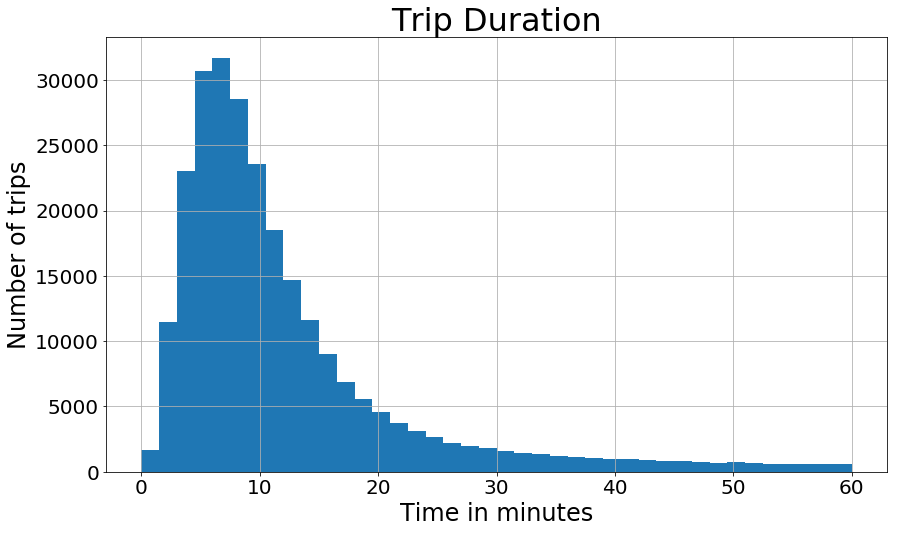

In [16]:
percentile_lim = 0.75
duration_mean = trips['Duration Seconds'].median() / 60
percentile = trips['Duration Seconds'].quantile(percentile_lim) / 60 
(trips['Duration Seconds'] / 60).hist(bins=40, range=(0, 60), xlabelsize=20, ylabelsize=20)
#plt.text(30.1, 20500, 'Median: %.2f' % (duration_mean), fontsize=30)
#plt.text(30.1, 15500, '%d %% percentile: %.2f' % (percentile_lim*100 ,percentile), fontsize=30)
plt.xlabel('Time in minutes', fontsize=24)
plt.ylabel('Number of trips', fontsize=24)
plt.title('Trip Duration', fontsize=32)
plt.savefig('Trip Duration.png', format='png', dpi=300)

A typical trip lasts about 10 minutes
<br>

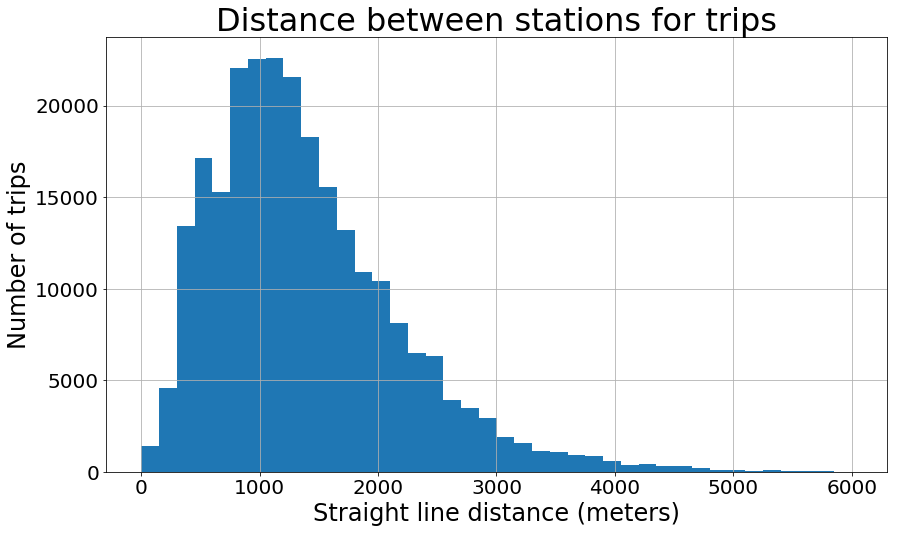

In [17]:
# 0 is a very common distance (travel back to self), ignore it
trips['Distance'].hist(bins=40, range=(1, 6000), xlabelsize=20, ylabelsize=20)
plt.xlabel('Straight line distance (meters)', fontsize=24)
plt.ylabel('Number of trips', fontsize=24)
plt.title('Distance between stations for trips', fontsize=32)
plt.savefig('Trip Distance.png', format='png', dpi=300)

A typical trip is about 1 km in straight line distance
<br>

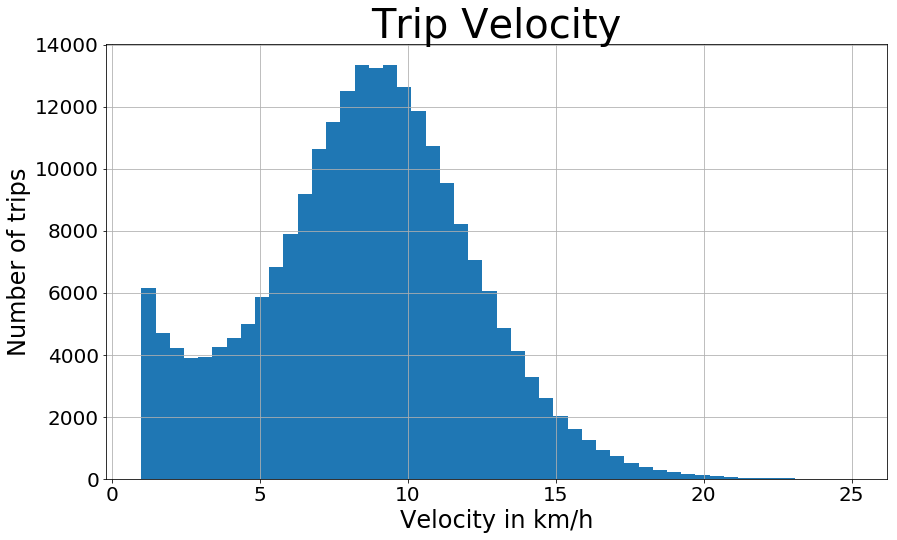

In [18]:
(trips['Velocity'] * 3.6).hist(bins=50, range=(1,25), xlabelsize=20, ylabelsize=20)
plt.xlabel('Velocity in km/h', fontsize=24)
plt.ylabel('Number of trips', fontsize=24)
plt.title('Trip Velocity', fontsize=40)
plt.savefig('Trip Velocity.png', format='png', dpi=300)

The velocity of a typical trip is about 10 km/h
<br>

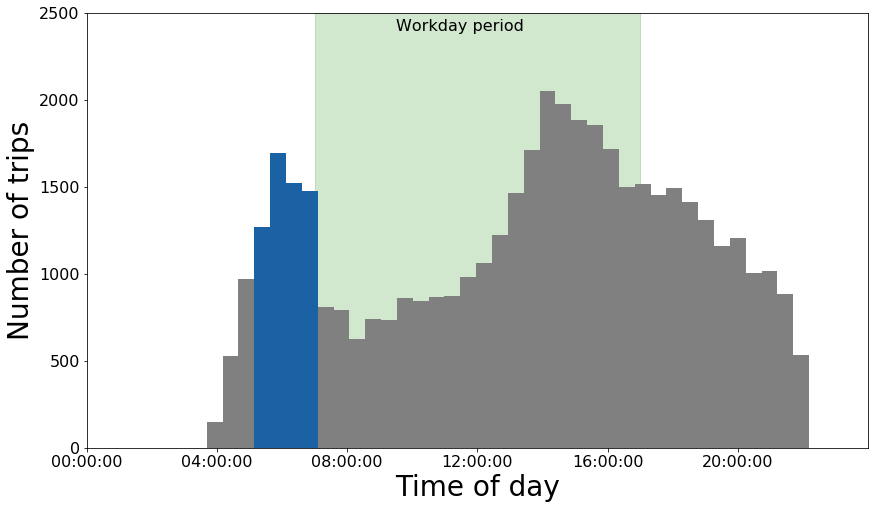

In [19]:
to_work = (5*3600, 7*3600)
timeofday = trips
timeofday['timeofday'] = trips.index.time
series = timeofday['timeofday']
perday = series[trips.index.weekday < 5]
oslo.plot_trip_times(perday, title='towork-trips', selected=to_work, scale=5.0);

The spike at the period 05:00 - 07:00 is marked in blue and is presumed to be the time when people go to work. The period marked in green is the workday period. In the afternoon the spike is not as well defined, and the people returning from work is not as easily seen. 

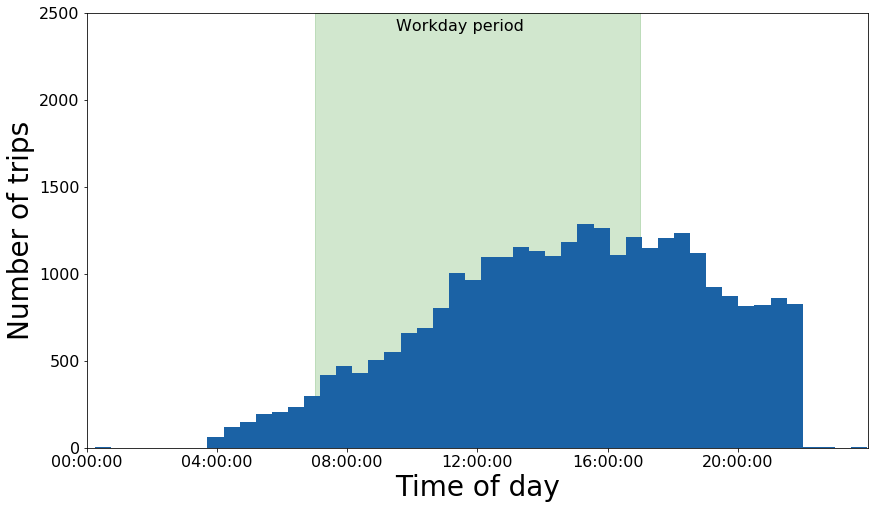

In [20]:
oslo.plot_trip_times(series[trips.index.weekday >= 5], title='weekend-trips', scale=2.0);

There are no clear spikes in the weekends, and people generally start their bike trips later in the day

## Station connectivity

In [21]:
df = trips
df = df[df.index.weekday >= 5]
clustered = oslo.cluster_connected(df, n_clusters=6)
oslo.plot_station_groups(stations, clustered)

This clustering method tries to find clusters that have a minimum number of trips between differnet clusters, but maximize trips inside them. We can clearly see that the clusters is separated into geographically parts of Oslo for weekends. 

In [22]:
df = trips[trips.index.weekday < 5 ]
clustered = oslo.cluster_connected(df, n_clusters=6)
oslo.plot_station_groups(stations, clustered)

We see a similar clustering for weekdays

In [23]:
df = trips[trips.index.weekday < 5 ]
df = df.between_time('5:00', '7:00')
clustered = oslo.cluster_connected(df, n_clusters=6)
oslo.plot_station_groups(stations, clustered)

For the period between 05:00 and 07:00 the clustering makes less sense. There is a huge cluster covering almost all of Oslo, and that makes it difficult to say anything about the trips. 

In [24]:
stats = oslo.cluster_stats(stations, trips, clustered)
stats

,0,1,2,3,4,5
0,58716.0,25088.0,12440.0,12319.0,6014.0,1512.0
1,29577.0,30310.0,7844.0,2818.0,2634.0,655.0
2,15404.0,8437.0,9242.0,3892.0,3293.0,1507.0
3,11766.0,2298.0,2541.0,7486.0,2185.0,242.0
4,7564.0,3082.0,3281.0,3144.0,3612.0,460.0
5,1753.0,761.0,1607.0,355.0,421.0,119.0


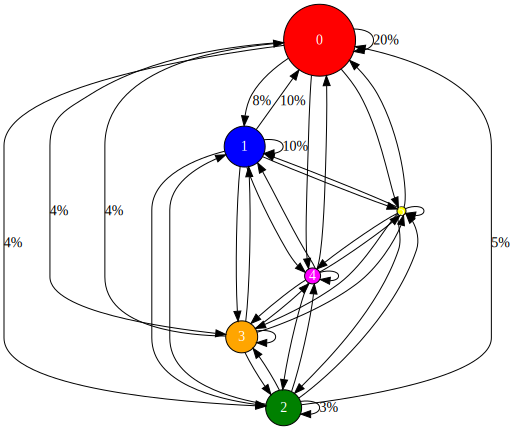

In [25]:
# Visualize clustered connectivity
dot = oslo.cluster_digraph(clustered, stats)

dot

## Clustering using Affinity Propagation
https://en.wikipedia.org/wiki/Affinity_propagation
Ref: D. Dueck Affinity Propagation: Clustering data by passing messages, PhD thesis, U. Toronto, 2009


In [26]:
# Commute time on weekdays
df = (trips[trips.index.weekday < 5 ]).between_time('5:00', '7:00')
clustered, centers, st = oslo.cluster_connected(df, n_clusters=6, method='affinitypropagation')
center_stations = list(map(lambda idx: st.values[idx], centers))
m = oslo.plot_station_groups(stations, clustered, center_stations)
m.save('affinity-cluster-workday-commute.html')
m

This clustering method is based on the number of trips between stations and shows which staitions are well connected to each other. We see that trips are centered on traffic hubs around Oslo S and Nationaltheatret and office areas in Skøyen. 

In [27]:
# In weekends
df = (trips[trips.index.weekday >= 5 ])
clustered, centers, st = oslo.cluster_connected(df, n_clusters=6, method='affinitypropagation')
center_stations = list(map(lambda idx: st.values[idx], centers))
m = oslo.plot_station_groups(stations, clustered, center_stations)
m.save('affinity-cluster-weekend.html')
m

In the weekends the trips are centered around social areas like Aker brygge, Grünerløkka, Majorstuen and Oslo Oper House. 